# London Tube
Simon Schmetz - Paola Carolina Suarez  
Network Analysis  
Master in Statistics for Data Science  
Universidad Carlos III de Madrid  

Data Source: https://github.com/jaron/railgraph

#### Introduction  

The "London Underground Network" refers to the metro system of London, UK, encompassing its stations and the connections between them. The network consists of 309 vertices (representing stations), and 370 edges (representing the metro line connections between stations). Notably, multiple metro lines can connect to the same station, resulting in multiple edges. As an undirected network, each edge signifies a bidirectional connection, meaning travel is possible in both directions between stations.



In [ ]:
# Load Libraries 
import pandas as pd
import scipy.io
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Read the Network
G = nx.read_graphml('data/london_tube/tubeDLR.graphml')

In [ ]:
# Extract labels from node data
labels = nx.get_node_attributes(G, 'label')

In [129]:
# Check if the graph is directed
if isinstance(G, nx.DiGraph):
    print("The graph is directed.")
else:
    print("The graph is undirected.")


#Count nodes
print("number of Nodes:", G.number_of_nodes())

#Count edges
print("number of Edges:", len(G.edges(data=True)))

# Find isolated vertices
print("Isolated Vertices: ",list(nx.isolates(G)))


The graph is undirected.
number of Nodes: 309
number of Edges: 370
Isolated Vertices:  []


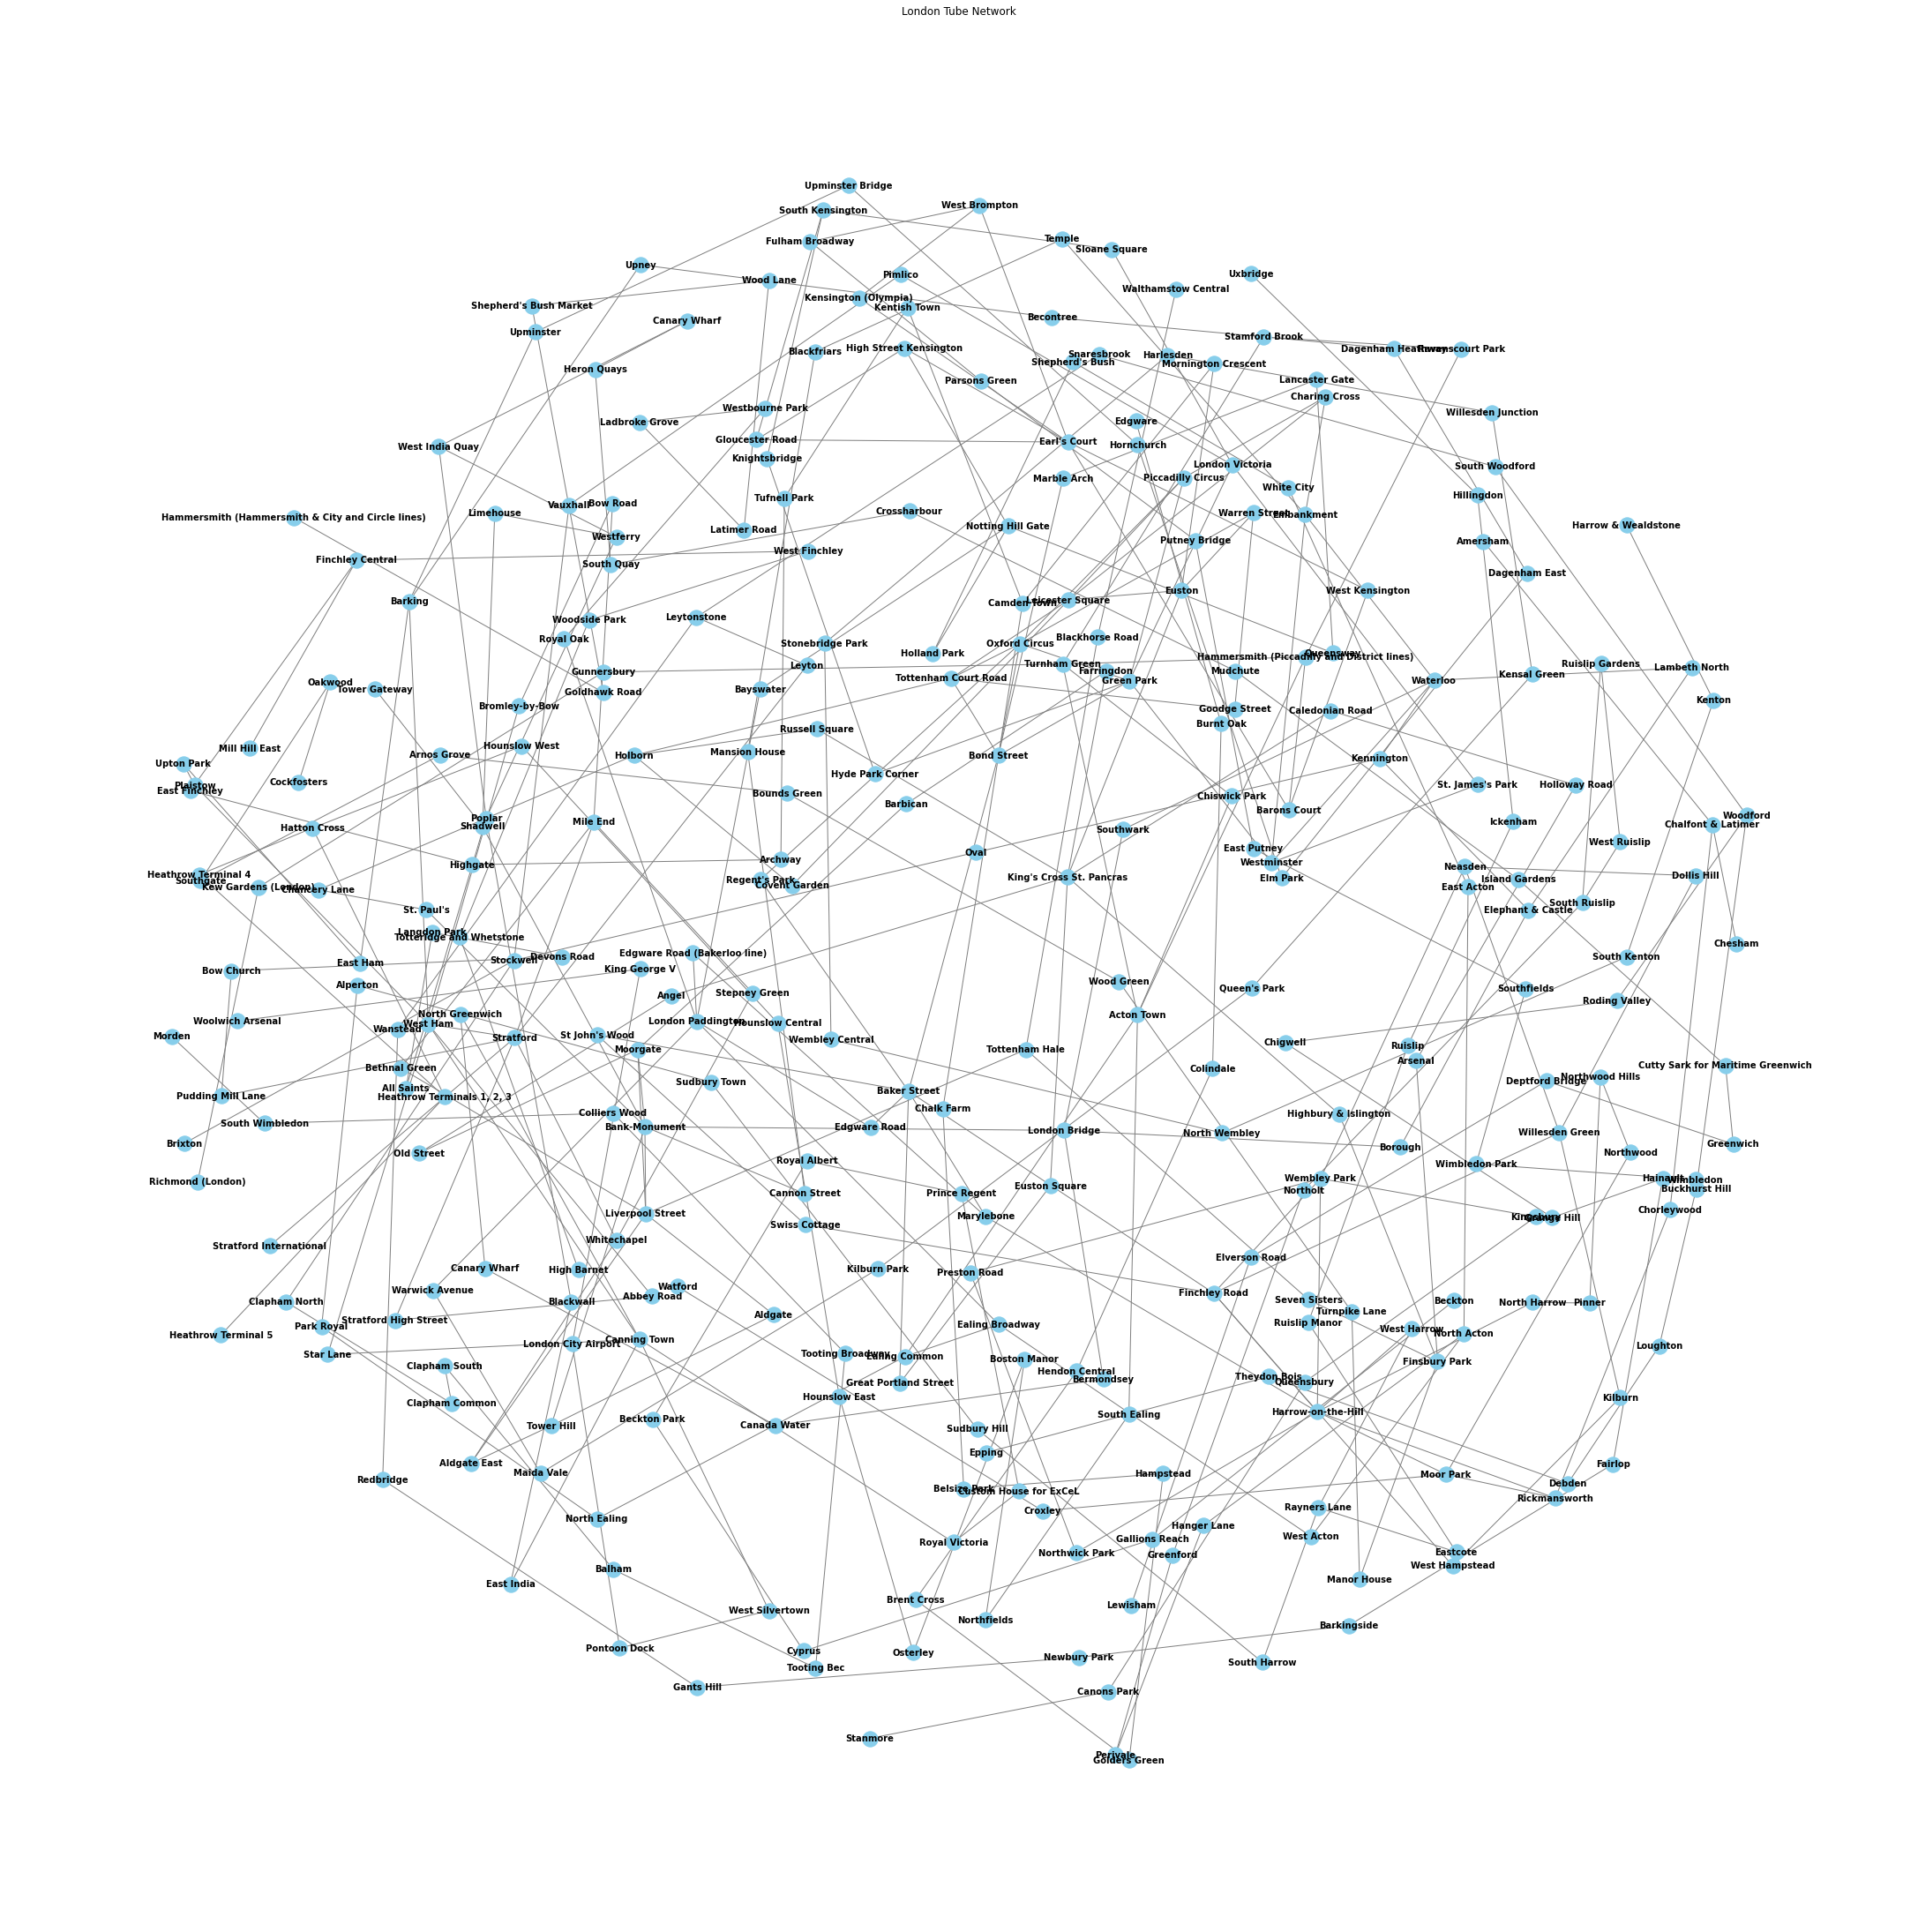

In [ ]:
#London Underground network

# Create the plot
plt.figure(figsize=(30, 30))

# Use spring_layout with larger spacing between nodes
pos = nx.spring_layout(G, seed=42, k=0.3)
nx.draw(G, pos, with_labels=True, labels=labels, node_size=300, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')

# Display the plot
plt.title("London Tube Network")
plt.show()


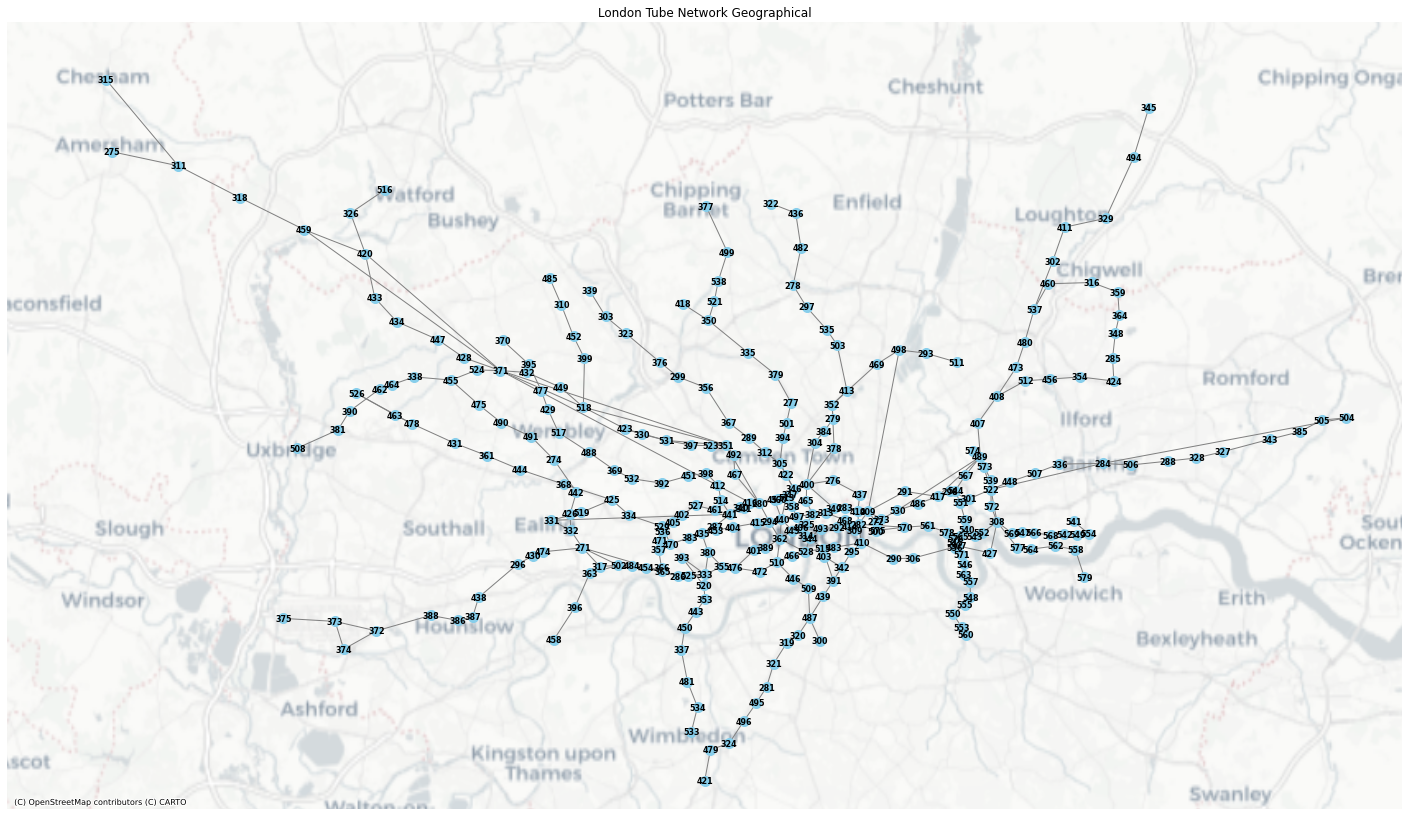

In [77]:
import contextily as ctx

pos_geo = {node: (float(data['longitude']), float(data['latitude'])) for node, data in G.nodes(data=True)}

# Create a plot
fig, ax = plt.subplots(figsize=(25, 25))  # More balanced size

# Set the extent to match London's approximate geographical coordinates
ax.set_xlim(-0.68, 0.29)
ax.set_ylim(51.39, 51.73)

# Ensure the correct aspect ratio
ax.set_aspect(1 / np.cos(np.radians((51.4 + 51.73) / 2)))  # Adjust for London's latitude

# Add a basemap
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron, zoom=10)

# Overlay the London Tube Network
nx.draw(G, pos=pos_geo, with_labels=True, node_size=100, node_color='skyblue', 
        font_size=8, font_weight='bold', edge_color='gray', ax=ax)

# Display the plot
plt.title("London Tube Network Geographical")
plt.show()


With the pice of code below, the adjecent verteces of a chosen vertex can be found and both their ID and the station names are printed

In [115]:

# Get the adjacent vertices
chosen_vertex = '309'

adjacent_vertices = list(G.neighbors(chosen_vertex))
print(f"Adjacent vertices of vertex {chosen_vertex}: {adjacent_vertices}")

# Print the labels of the adjacent vertices
adjacent_labels = [labels[vertex] for vertex in adjacent_vertices]
print(f"Adjacent vertices of vertex {labels[chosen_vertex]}: {adjacent_labels}")

Adjacent vertices of vertex 309: ['282', '414']
Adjacent vertices of vertex Cannon Street: ['Bank-Monument', 'Mansion House']


The Nodes and Edges are already delivered with a wide array of attributes, where the contextually most intereisting for nodes is the longitude and lattitude, allowing for geographically placing the nodes. From this, a edge attribute can be derived by calculating the euclidean distance of an edge.

In [ ]:
# Attributes

# Nodes
unique_keys = set().union(*(data.keys() for _, data in G.nodes(data=True)))
print(list(unique_keys))

# Edges
unique_edge_keys = set().union(*(data.keys() for _, _, data in G.edges(data=True)))
print(list(unique_edge_keys))

['stationReference', 'Clustering Coefficient', 'In-Degree', 'Number of triangles', 'Betweenness Centrality', 'r', 'b', 'x', 'Degree', 'y', 'Out-Degree', 'PageRank', 'Eccentricity', 'label', 'latitude', 'longitude', 'size', 'Eigenvector Centrality', 'longitude_copy', 'displayName', 'Closeness Centrality', 'g', 'latitude_copy']
['line', 'Neo4j Relationship Type', 'weight']


We thus calculate the lengths of all arcs using the euclidean distance.

In [65]:
# Add "dist" attribute to each edge based on the euclidean distance between nodes in kilometers
for u, v, data in G.edges(data=True):
    lon1, lat1 = pos_geo[u]
    lon2, lat2 = pos_geo[v]
    distance = np.sqrt((lon2 - lon1)**2 + (lat2 - lat1)**2) * 111  # Convert radiants to kilometers
    data['dist'] = distance

# Show first two results
list(G.edges(data=True))[:2]  

[('271',
  '317',
  {'weight': 1.0,
   'Neo4j Relationship Type': 'CONNECTS',
   'line': 'District_line',
   'dist': 1.6254963703434686}),
 ('271',
  '332',
  {'weight': 1.0,
   'Neo4j Relationship Type': 'CONNECTS',
   'line': 'Piccadilly_line',
   'dist': 1.225331408232096})]

A histogram can then be plotted to show the distribution of the distances and the mean distance between stations. It has to be remembered as the distance is a linear approximation (e.g. euclidean distance) and the effective distances that are traveled between stations are slightly higher.

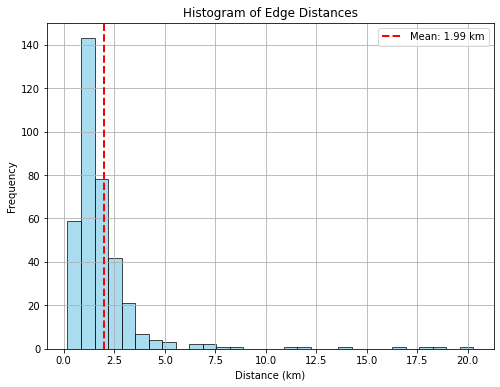

In [64]:
# Plot the histogram
distances = [data['dist'] for _, _, data in G.edges(data=True) if 'dist' in data]
mean_distance = np.mean(distances)

plt.figure(figsize=(8, 6))
plt.hist(distances, bins=30, edgecolor='black', color='skyblue', alpha=0.7)
plt.axvline(mean_distance, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_distance:.2f} km')
plt.title('Histogram of Edge Distances')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


## Degrees Graph Characteristics Analyis

To start of the analysis of the graph characteristics, the average degree of the arcs and the distribution of the degrees is investigated. The average degree yields 2.39, which is not unexpected as most stations are expected to be part of a individual line with two arcs, one connecting the previous and one the following station on the line.

In [ ]:
# Calculate the average degree of the graph
average_degree = sum(dict(G.degree()).values()) / len(G.nodes())

print(f"Average degree of the network: {average_degree:.2f}")

Average degree of the network: 2.39


This assumption about the majority of stations having two arcs is validated by the empirical distribution of the degrees, showing degrees = 2 being by far the most common one. Beyond that, there are end/start stations of lines with degree = 1 and hubs that connect more than one line and correspondingly have more than two edges.

The top 5 nodes with the highest degrees in the network are Harrow-on-the-Hill, Baker Street, Bank-Monument, King's Cross St. Pancras, and Stratford. Harrow-on-the-Hill stands out with the highest degree of 8, indicating it has the most connections in the network. The other four stations—Baker Street, Bank-Monument, King's Cross St. Pancras, and Stratford—each have a degree of 7, showing they are all well-connected with a similar number of edges. These stations are central hubs in the network, with varying but significant levels of connectivity. 
These stations are all above the average degree of the network, which is 2.39. Their higher degrees suggest they are significantly more connected than the average station, reflecting their importance in facilitating movement and providing multiple transport links.
Some initial assumptions about their locations and roles in London transportation help provide context, a more detailed analysis would involve evaluating commuter traffic, station facilities, and transport links to further understand their importance within the network.

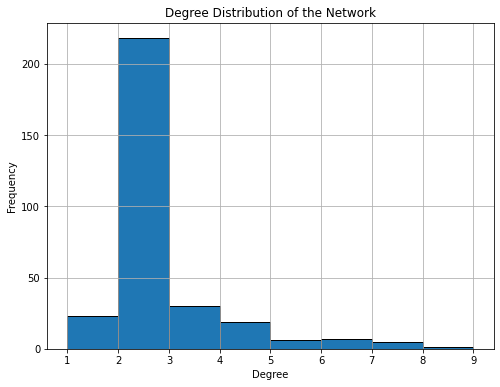


Top 5 nodes with the highest degrees:
Node: 371, Label: Harrow-on-the-Hill, Degree: 8
Node: 280, Label: Baker Street, Degree: 7
Node: 282, Label: Bank-Monument, Degree: 7
Node: 400, Label: King's Cross St. Pancras, Degree: 7
Node: 489, Label: Stratford, Degree: 7


In [ ]:
# Degree of each node in the graph
degrees = dict(G.degree())  # {node: degree}

# Degree distribution (histogram)
degree_sequence = [degree for node, degree in degrees.items()]

# Plot the degree distribution
plt.figure(figsize=(8, 6))
plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence) + 2), edgecolor='black')
plt.title('Degree Distribution of the Network')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Find the top 5 nodes with the highest degrees
sorted_nodes_by_degree = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 nodes with their degrees and labels
print("\nTop 5 nodes with the highest degrees:")
for node, degree in sorted_nodes_by_degree:
    label = G.nodes[node].get('label', 'No Label')
    print(f"Node: {node}, Label: {label}, Degree: {degree}")

## Circles and Subgraphs

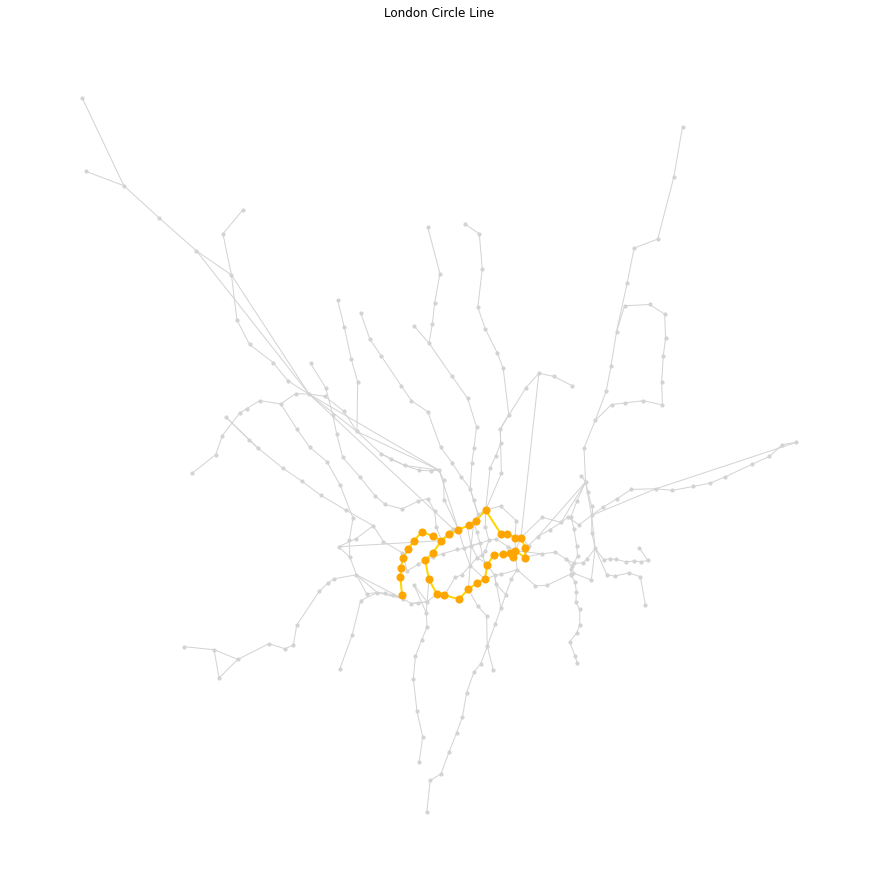

In [125]:
circle_line_stations = [
    "Hammersmith (Hammersmith & City and Circle lines)",
    "Goldhawk Road",
    "Shepherd's Bush Market",
    "Wood Lane",
    "Latimer Road",
    "Ladbroke Grove",
    "Westbourne Park",
    "Royal Oak",
    "London Paddington",
    "Edgware Road",
    "Baker Street",
    "Great Portland Street",
    "Euston Square",
    "King's Cross St. Pancras",
    "Farringdon",
    "Barbican",
    "Moorgate",
    "Liverpool Street",
    "Aldgate",
    "Tower Hill",
    "Bank-Monument",
    "Cannon Street",
    "Mansion House",
    "Blackfriars",
    "Temple",
    "Embankment",
    "Westminster",
    "St. James's Park",
    "London Victoria",
    "Sloane Square",
    "South Kensington",
    "Gloucester Road",
    "High Street Kensington",
    "Notting Hill Gate",
    "Bayswater"
]


# Get station edges and nodes
circle_line_station_ids = [node for node, name in labels.items() if name in circle_line_stations]
circle_line_edges = [(u, v) for u, v in G.edges() if u in circle_line_station_ids and v in circle_line_station_ids]
circle_line_edges = [edge for edge in circle_line_edges if edge not in [('282', '409'), ('282', '419')]] # remove two incorrect edges
circle_line_nodes = set(circle_line_station_ids)

# Plot
plt.figure(figsize=(12, 12))

nx.draw(G, pos = pos_geo, with_labels=False, node_size=10, node_color='lightgray', edge_color='lightgray')
nx.draw_networkx_edges(G, pos= pos_geo, edgelist=circle_line_edges, edge_color='gold', width=2)
nx.draw_networkx_nodes(G, pos = pos_geo, nodelist=circle_line_nodes, node_color='orange', node_size=50)
nx.draw_networkx_labels(G, pos, labels={node: labels[node] for node in circle_line_nodes}, font_size=8)

plt.title("London Circle Line")
plt.show()




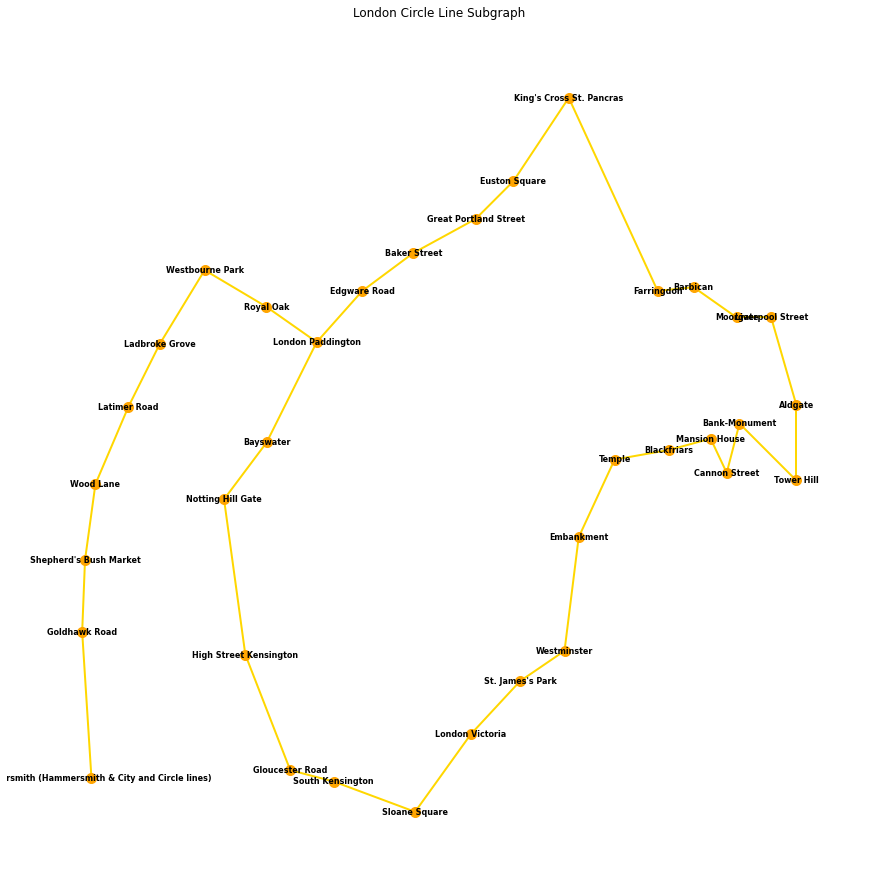

In [128]:
# Extract the subgraph of the Circle Line
circle_line_subgraph = G.subgraph(circle_line_nodes)

# Plot the Circle Line subgraph
plt.figure(figsize=(12, 12))

nx.draw(circle_line_subgraph, pos=pos_geo, with_labels=True, labels={node: labels[node] for node in circle_line_nodes},
    edgelist=circle_line_edges, node_size=100, node_color='orange', font_size=8, font_weight='bold', edge_color='gold', width=2)

plt.title("London Circle Line Subgraph")
plt.show()